## Загружаем необходимые библиотеки

In [466]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 

## Предобработка данных

 ### 1. Загружаем данные

In [467]:
url = "https://raw.githubusercontent.com/ArisovaAnastasia/MachineLearning/master/BankCustomerData.csv"
data = pd.read_csv(url)

In [468]:
data.shape

(42639, 17)

### 2. Обработка пропущенных значений
Заменим пропущенные значения категориальных признаков 'job', 'education', 'contact' на соответствующие моды:

In [469]:
data = data.astype({"job":'category', "education":'category', "contact":'category'}) 
data.replace({'job':"unknown",'education':"unknown",'contact':"unknown"},{'job':data['job'].mode().iloc[0],'education':data['education'].mode().iloc[0],'contact':data['contact'].mode().iloc[0]}, inplace=True)
for col in ['job', 'education', 'contact']:
    data[col].cat.remove_unused_categories(inplace=True)

D:\Program\anaconda\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### 3. Обработка категориальных признаков

In [470]:
data['default'] = pd.factorize(data['default'], sort = True)[0]
data['housing'] = pd.factorize(data['housing'],sort = True)[0]
data['loan'] = pd.factorize(data['loan'],sort = True)[0]

for col in ['job', 'marital', 'education', 'contact', 'month','poutcome']:
    dummies = pd.get_dummies(data[col])
    data = pd.concat((data, dummies), axis=1)
    data = data.drop([col],  axis=1)

In [471]:
data_stand = data.drop(['term_deposit'], axis=1)
data_stand = (data_stand - data_stand.mean(axis = 0))/data_stand.std(axis = 0)

In [472]:
data = pd.concat((data_stand, data['term_deposit']), axis=1)

### 4. Обработка выбросов

In [473]:
rows_to_drop = data[
    (data['balance'] < data['balance'].quantile(0.005)) | (data['balance'] > data['balance'].quantile(0.995))].index
data = data.drop(rows_to_drop)

## Разбиваем данные на обучающую и тестовую выборки

In [474]:
from sklearn.model_selection import train_test_split
y = data.term_deposit
X = data.drop(['term_deposit'], axis=1)

In [475]:
y = y.apply(lambda x: 1 if x == "yes" else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 21)

## Обучаем классификатор

In [476]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes = (30,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          max_iter = 1000,
                          random_state = 42)

In [477]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 18.6 s


MLPClassifier(activation='logistic', hidden_layer_sizes=(30,), max_iter=1000,
              random_state=42, solver='lbfgs')

In [478]:
X_train.shape, X_test.shape

((37989, 45), (4222, 45))

In [479]:
from sklearn.metrics import accuracy_score
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print("Error on X_train: ", 1-accuracy_score(y_train, y_train_pred))
print("Error on X_test: ", 1-accuracy_score(y_test, y_test_pred))

Error on X_train:  0.045434204638184705
Error on X_test:  0.09924206537186164


## Подбор параметра alpha

In [480]:
alpha_arr = np.logspace(-2, 4, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for my_alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = my_alpha, hidden_layer_sizes = (30,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

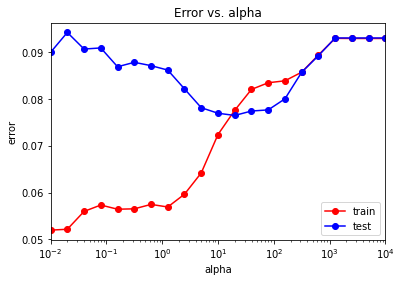

In [481]:
plt.semilogx(alpha_arr, train_err, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

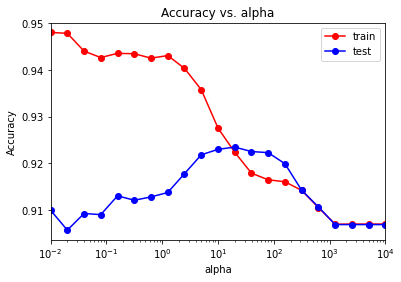

In [482]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

In [483]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print("Min error on X_train: ", min_train_err)
print("Min error on X_test: ", min_test_err)

Min error on X_train:  0.051962410171365395
Min error on X_test:  0.07650402652771199


In [484]:
alpha_opt = alpha_arr[test_err == min_test_err]
print("alpha optimal = ", alpha_opt[0])

alpha optimal =  19.952623149688787


In [485]:
alpha_opt = alpha_opt[0]

In [486]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (30,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print("Error on X_train with optimal alpha: ", np.mean(y_train != y_train_pred))
print("Error on X_test with optimal alpha: ", np.mean(y_test != y_test_pred))

Error on X_train with optimal alpha:  0.07760141093474426
Error on X_test with optimal alpha:  0.07650402652771199


In [487]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3829
           1       0.66      0.37      0.47       393

    accuracy                           0.92      4222
   macro avg       0.80      0.67      0.72      4222
weighted avg       0.91      0.92      0.91      4222



In [488]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[3755  249]
 [  74  144]]


## Подбор количества нейронов в первом скрытом слое

In [489]:
%%time
hidden_layer_arr = np.arange(1, 51)
test_err = []
train_err = []
train_acc = []
test_acc = []

for my_hidden_layer_sizes in hidden_layer_arr:
    mlp_model = MLPClassifier(alpha = alpha_opt, 
                              hidden_layer_sizes = my_hidden_layer_sizes,
                              solver = 'lbfgs', 
                              max_iter = 1000, 
                              activation = 'logistic',
                              random_state = 42)
    
    
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Wall time: 2min 54s


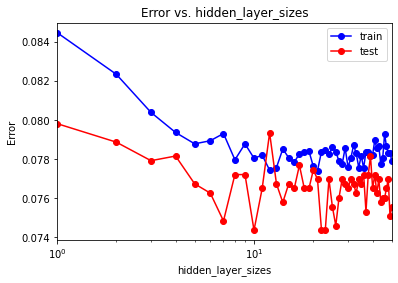

In [490]:
plt.semilogx(hidden_layer, train_err, 'b-o', label = 'train')
plt.semilogx(hidden_layer, test_err, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer), np.max(hidden_layer)])
plt.title('Error vs. hidden_layer_sizes')
plt.xlabel('hidden_layer_sizes')
plt.ylabel('Error')
plt.legend()
pass

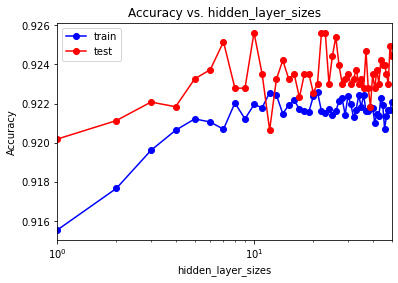

In [491]:
plt.semilogx(hidden_layer, train_acc, 'b-o', label = 'train')
plt.semilogx(hidden_layer, test_acc, 'r-o', label = 'test')
plt.xlim([np.min(hidden_layer), np.max(hidden_layer)])
plt.title('Accuracy vs. hidden_layer_sizes')
plt.xlabel('hidden_layer_sizes')
plt.ylabel('Accuracy')
plt.legend()
pass

In [492]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print("Min error on X_train with optimal alpha: ", min_train_err)
print("Min error on X_test with optimal alpha: ", min_test_err)

Min error on X_train with optimal alpha:  0.07741714706888836
Min error on X_test with optimal alpha:  0.07437233538607295


In [493]:
hidden_layer_local_opt = hidden_layer[test_err == min_test_err][0]
print('hidden_layer_sizes optimal = ', hidden_layer_local_opt)

hidden_layer_sizes optimal =  10


In [494]:
%%time
mlp_model = MLPClassifier(alpha = alpha_opt, 
                          hidden_layer_sizes = hidden_layer_local_opt,
                          solver = 'lbfgs', 
                          max_iter = 1000, 
                          activation = 'logistic',
                          random_state = 42)

mlp_model.fit(X_train, y_train)

Wall time: 1.27 s


MLPClassifier(activation='logistic', alpha=19.952623149688787,
              hidden_layer_sizes=10, max_iter=1000, random_state=42,
              solver='lbfgs')

In [495]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

err_train = np.mean(y_train != y_train_pred)
err_test = np.mean(y_test != y_test_pred)

print("Error on X_train with optimal alpha and hidden_layer_sizes: ", err_train)
print("Error on X_test with optimal alpha and hidden_layer_sizes: ", err_test)

Error on X_train with optimal alpha and hidden_layer_sizes:  0.07804890889468004
Error on X_test with optimal alpha and hidden_layer_sizes:  0.07437233538607295


## Матрица рассогласования

In [498]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[3763  248]
 [  66  145]]


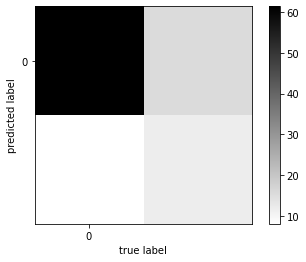

In [500]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(1))
plt.yticks(range(1))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

## Другие метрики качества

In [501]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3829
           1       0.69      0.37      0.48       393

    accuracy                           0.93      4222
   macro avg       0.81      0.68      0.72      4222
weighted avg       0.91      0.93      0.92      4222



## Выводы:

1. Наименьшая полученная ошибка на тестовой выборке равна 0.0743 Она была получена при оптимальном параметре alpha_opt = 19.95 и оптимальном количестве нейронов в первом скрытом слое hidden_layer_sizes optimal =  10